## 0. Introduction
In this notebook, we will be using CountVectorizer (an sklearn implementation of Bag-of-Words) model to convert the texts to a numerical dataset which can be then mapped against the output variables **"toxic","severe_toxic","obscene","threat","insult","identity_hate"** and any model can be used learn the dependency of the output variable i.e. toxic type in this case on occurence of words. For now, we will be using **Naive Bayes and Logistic Regression** on top of the dataset created by CountVectorizer and will choose the one giving the best results on validation dataset to predict on the test dataset. We will be using **Multi Output Classifier** wrapper from sklearn to create models for all the 6 output variables
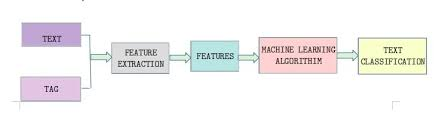


### Table of Contents:
[1. Importing Libraries](#1)

[2. Reading Dataset](#2)

[3. Splitting Dataset into training and validation sets](#3)

[4. Basic Preprocessing and Creating Bag of Words](#4)

[5. Initialising and Training Multi Output Classifier Models](#5)

[6. Measuring performance on Validation data](#6)

[7. Predicting and Submitting for Test Data](#7)

[8. Model Interpretation](#8)

[9. TODOs](#9)

## 1. Importing Libraries <a class="anchor" id="1"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from statistics import mean 

import string 

#Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#To set precision to 3 decimals
pd.options.display.float_format = "{:,.2f}".format

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## 2.Reading Dataset <a class="anchor" id="2"></a>
All the datasets are provided as zipped files. First we will have to unzip them and then read them into dataframes

In [2]:
#unzipping all the zip folders and saving it /kaggle/working and saving the verbose in /dev/null to keep it quiet
# -o for overwrite -d for destination directory of unzipped file
!unzip -o '/kaggle/input/jigsaw-toxic-comment-classification-challenge/*.zip' -d /kaggle/working > /dev/null


4 archives were successfully processed.


In [3]:
#Reading input csv files
train_text = pd.read_csv("train.csv")
test_text = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

print(train_text.shape, test_text.shape, sample_submission.shape)
train_text.head()

(159571, 8) (153164, 2) (153164, 7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_text.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.50,0.50,0.50,0.50,0.50,0.50
1,0000247867823ef7,0.50,0.50,0.50,0.50,0.50,0.50
2,00013b17ad220c46,0.50,0.50,0.50,0.50,0.50,0.50
3,00017563c3f7919a,0.50,0.50,0.50,0.50,0.50,0.50
4,00017695ad8997eb,0.50,0.50,0.50,0.50,0.50,0.50


In [6]:
#Looking at the distribution of traget variables
y_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
train_text[y_cols].apply(pd.Series.value_counts, args = (True, True, False, None, False))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.90,0.99,0.95,1.00,0.95,0.99
1,0.10,0.01,0.05,0.00,0.05,0.01


We have around 160k training texts and about 153k test texts

We have a class imbalance in almost all the training target variables.
1. Toxic Statements: 10%
2. Severe Toxic Statements: 1%
3. Obscene Statements: 5%
4. Threat Statements: 0.3%
5. Insult Statements: 5%
6. Identity Hate Statements: 0.9%

## 3. Splitting Dataset into training and validation sets <a class="anchor" id="3"></a>

In [7]:
#Dependent Variable
X = train_text.comment_text
#Independent Variables
y = train_text[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]
#Splitting for checking the performance of the models on a holdout dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = True, random_state = 123)

In [8]:
X_train.shape, X_val.shape

((119678,), (39893,))

## 4. Basic Preprocessing and Creating Bag of Words <a class="anchor" id="4"></a>

In [9]:
#importing stop words like in, the, of so that these can be removed from texts
#as these words dont help in determining the classes(Whether a sentence is toxic or not)
stop_words = stop_words.ENGLISH_STOP_WORDS
#Function for basic cleaning/preprocessing texts
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of stopwords
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    return doc.lower()

Creating a bag of words model with a maximum of 5000 most-frequent words (as including all the words will make the dataset sparse and will only add noise).Also, Clean the dataset when creating the dataset using bag of words

In [10]:
vect = CountVectorizer(max_features= 5000, preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train)
X_val_dtm = vect.transform(X_val)

print(X_train_dtm.shape, X_val_dtm.shape)

(119678, 5000) (39893, 5000)


As we can see the same number of rows in train and validation dataset but 5000 columns which are essentially number of occurences of the 5000 most common words in each sentence

In [11]:
pd.DataFrame(X_train_dtm.A[:5], columns = vect.get_feature_names())

,abc,abide,ability,able,abortion,about,absence,absolute,absolutely,absurd,...,yourselfgo,youth,youtube,youve,ytmndin,yugoslavia,zealand,zero,zionist,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Above, we can see the bag of words.For e.g. abide is present in 1st sentence 0 times
The Bag of words is pretty much sparse
This will be the input for a Machine Learning Classifier

## 5. Initialising and Training Multi Output Classifier Models <a class="anchor" id="5"></a>

Since we need to classify each sentence as toxic or not, severe_toxic or not, obscene or not, threat or not, insult or not and identity_hate or not, we need to classify the sentence against 6 output variables (This is called Multi-Label Classification which is different from mult-class classification where a target variable has more than 2 options e.g. a sentence can be positive, negative and neutral)

For the same, we will be using MultiOutputClassifier from sklearn which as mentioned earlier is a wrapper.This strategy consists of fitting one classifier per target.

In [12]:
#Initializing and fitting models on Training Data
#Naive Bayes Model
nb = MultiOutputClassifier(MultinomialNB()).fit(X_train_dtm, y_train)
#Logistic Regression Model (As we have unbalanced dataset, we use class_weight which will use inverse
#of counts of that class. It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1)
lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=3000)) \
                    .fit(X_train_dtm, y_train)

I tried using Support Vector Classifier as well, but that took a lot of time to train without giving the best results

## 6. Measuring performance on Validation data <a class="anchor" id="6"></a>
Since, the competition uses mean ROC-AUC as the evaluation metric, we will be using the same in the notebook.
We will compare the mean ROC-AUC across all the 3 models we have trained.
We will be using predict_proba function of models instead of predict which gives us the probability scores instead of predicted value based on a threshold of 0.5, as it is used by the roc_auc_measure.

In [13]:
#Function for calculating roc auc with given actual binary values across target variables
#and the probability score made by the model
def calculate_roc_auc(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [14]:
#Creating an empty list of results
results = []
#Making predictions from all the trained models and measure performance for each
for model in [nb,lr]:
    #Extracting name of the model
    est = type(model.estimator).__name__
    #Actual output variables
    y_vals = y_val.to_numpy()
    #Model Probabilities for class 1 of each of the target variables
    y_preds = np.transpose(np.array(model.predict_proba(X_val_dtm))[:,:,1])
    #Calculate Mean of the ROC-AUC
    mean_auc = mean(calculate_roc_auc(y_vals,y_preds))
    #Append the name of the model and the mean_roc_auc into the results list
    results.append([est, mean_auc])
    
#Output the results as a table
pd.DataFrame(results, columns = ["Model","Mean AUC"])

,Model,Mean AUC
0,MultinomialNB,0.94
1,LogisticRegression,0.94


As we can see, Both the models perform really good with LR performing slightly better. So, we will use it as the final model to submit the predictions for the test data. Also, these simple models give pretty good results without much of a hassle or technical know-how, that is why they are still used widely.

A bit on Logistic Regression is no harm.

The ***logistic model*** (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. **Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one.**

Below is the image most commonly used image for Logistic Regression
![](https://www.saedsayad.com/images/LogReg_1.png)

By simple transformation, the logistic regression equation can be written in terms of an odds ratio.
![](https://www.saedsayad.com/images/Logistic_odd.png)

Finally, taking the natural log of both sides, we can write the equation in terms of log-odds (logit) which is a linear function of the predictors.
![](https://www.saedsayad.com/images/Logit.png)

The coefficient (b1) is the amount the logit (log-odds) changes with a one unit change in x. 

For e.g. if the equation is 1+2x i.e. b0 = 1 and b1 = 2. 
Increasing x by 1 increases the log-odds by 2 and the odds that Y=1 increase by a factor of 10^2 . Note that the probability of Y=1 has also increased, but it has not increased by as much as the odds have increased.

This was about the logistic function.

Now to find the best dividing line (in other terms reduce the loss function), Logistic Regression also use Gradient Descent but with a different loss function (Linear Regression uses Mean squared error). Logistic Regression uses log loss/ maximum likelihood estimation (MLE) function

![](https://i.stack.imgur.com/XbU4S.png)

where m is the number of samples (as we take the average), y is the actual value and h(x) is the ouput of the model

## 7. Predicting and Submitting for Test Data <a class="anchor" id="7"></a>

In [15]:
# Merging the test dataset with sample_submission to have all the columns:
#id,text_data and the target variables in one dataframe
df_test = pd.merge(test_text, sample_submission, on = "id")
#Transform the test dataset as well based on Bag of Words/ Count Vectorizer as the Logistic model would 
#expect the same
X_test_dtm = vect.transform(df_test["comment_text"])
#Use the Logistic Regression model to output probabilities and take the probability for class 1
y_preds = np.transpose(np.array(lr.predict_proba(X_test_dtm))[:,:,1])
#Assign the predictions by the model in the final test dataset
df_test[y_cols] = y_preds
#Drop Comment Text as the sample submission doesnt have it and wouldnt be expected
df_test.drop(["comment_text"], axis = 1, inplace = True)
#Save the dataset as a csv to submit it
df_test.to_csv("sample_submission.csv", index = False)

## 8. Model Interpretation <a class="anchor" id="8"></a>
This is the most exciting part atleast for me. Since, we are just using a simple Logistic Regression model, we can directly use the coefficient values of the model to get an understanding of the predictions made. By doing so, which feature is importance or which word makes a sentence toxic. If we would use a complex model, we could go for SHAP or LIME.
Also, since we have 6 output variables, we will have 6 feature importances which will be interesting to see

In [16]:
#Assigning the feature names to an empty list
feat_impts = [vect.get_feature_names()]
#For all the models save the feature importances in the list.estimators_ would give the internal models used by the multioutput regressor
for clf in lr.estimators_:
    feat_impts.append(clf.coef_.flatten())
#Saving the results in a dataframe
df_feats_impts = pd.DataFrame(np.transpose(np.array(feat_impts)), columns = ["word","toxic","severe_toxic","obscene","threat","insult","identity_hate"])
#Converting Feature Importance Columns from string to float
df_feats_impts[y_cols] = df_feats_impts[y_cols].astype("float32")
df_feats_impts.head()

,word,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,abc,-0.96,-0.27,-0.78,-1.14,0.14,-0.77
1,abide,-0.71,-0.03,0.31,-0.18,-0.42,-0.15
2,ability,0.31,-0.34,-0.13,-0.33,-0.39,-0.90
3,able,-0.47,-0.47,0.02,-1.49,-0.81,-0.86
4,abortion,-1.37,-0.07,0.56,-0.05,0.58,0.87


We will look at Top 5 words which determine if the sentence is a toxic-type or not according to the model

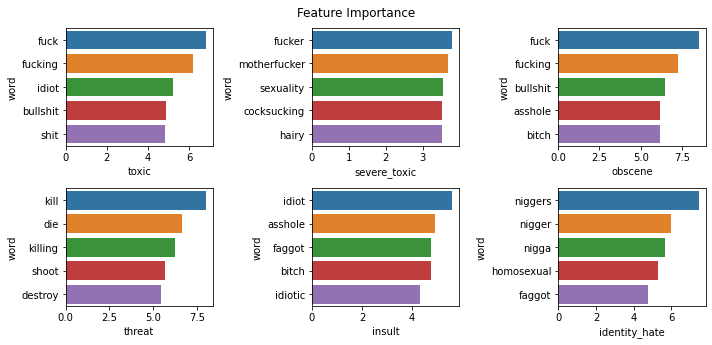

In [17]:
#Creating Individual Feature Importance table by sorting on specific toxic-type column and selecting top 5 words
toxic_fi = df_feats_impts[["word","toxic"]].sort_values(by = "toxic", ascending = False).head()
severe_toxic_fi = df_feats_impts[["word","severe_toxic"]].sort_values(by = "severe_toxic", ascending = False).head()
obscene_fi = df_feats_impts[["word","obscene"]].sort_values(by = "obscene", ascending = False).head()
threat_fi = df_feats_impts[["word","threat"]].sort_values(by = "threat", ascending = False).head()
insult_fi = df_feats_impts[["word","insult"]].sort_values(by = "insult", ascending = False).head()
identity_hate_fi = df_feats_impts[["word","identity_hate"]].sort_values(by = "identity_hate", ascending = False).head()

#Plotting top 5 words based on coefficient values from the LR model
fig,(ax1, ax2) =  plt.subplots(2,3,figsize=(10,5))
sns.barplot(x = "toxic", y = "word", ax = ax1[0], data = toxic_fi)
sns.barplot(x = "severe_toxic", y = "word", ax = ax1[1], data = severe_toxic_fi)
sns.barplot(x = "obscene", y = "word", ax = ax1[2], data = obscene_fi)
sns.barplot(x = "threat", y = "word", ax = ax2[0], data = threat_fi)
sns.barplot(x = "insult", y = "word", ax = ax2[1], data = insult_fi)
sns.barplot(x = "identity_hate", y = "word", ax = ax2[2], data = identity_hate_fi)
plt.suptitle("Feature Importance")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see that the models are quite rightly selecting the most important features and it makes complete sense

For e.g. for threats - words like kill, shoot, destroy etc are most important

for identity hate - words like nigger, nigga, homosexual, faggot

most important words for toxic are less extreme than most important words for severe toxic.

## 9. TODOs: <a class="anchor" id="9"></a>
1. Try TF-IDF instead of CountVectorizer 
TF-IDF tend to perform better than CountVectorizer in some cases
2. Try ensemble models instead of Vanilla ML models
Bagging and Boosting models give better results than classic ML techniques in most cases
3. Better Text Preprocessing
Typo correction etc can be done to further improve the model

***Do upvote if you find it helpful 😁***